Simple MPC using Casadi

In [32]:
from pyparsing import Dict
import casadi as ca
import numpy as np

class MPC:

    def __init__(
            self,
            N: int,         # horizon length
            f: callable,    # xdot = f(x,u)
            J: callable,    # cost function
            n: int,         # state dimension
            m: int,         # input dimension
            dt: float,      # time step
            x_constraints: callable = None, # constraints function
            u_constraints: callable = None, # constraints functions
        ) -> None:

        self.N = N
        self.f = f
        self.J = J
        self.x_constraints = x_constraints
        self.u_constraints = u_constraints
        self.dt = dt
        self.n = n
        self.m = m

        # create optimizer container and define its optimization variables
        self.opti = ca.Opti()
        # opti variables are optimized variables, we can only change their initial pre-optimized value at runtime
        self.X = self.opti.variable(n, N+1) # first state plays no role
        self.U = self.opti.variable(m, N) # final input plays no role

        # apply initial condition constraints
        self.init = self.opti.parameter(n,1) # opti parameters are non-optimized variables that we can change at runtime
        self.opti.set_value(self.init, np.zeros((n, 1)))
        self.opti.subject_to(self.X[:,0] == self.init)

        # apply dynamics constraints with euler integrator
        for k in range(N):
            self.opti.subject_to(self.X[:,k+1] == self.X[:,k] + f(self.X[:,k], self.U[:,k])*dt)

        # apply state and input constraints
        if x_constraints is not None:
            for k in range(N+1):
                self.opti.subject_to(x_constraints(self.X[:,k]) >= 0)

        if u_constraints is not None:
            for k in range(N):
                self.opti.subject_to(u_constraints(self.U[k]) >= 0)

            
        # define objective function
        self.opti.minimize(sum(J(self.X[:,k], self.U[k]) for k in range(N)))


        # tell the opti container we want to use IPOPT to optimize, and define settings for the solver
        opts = {
            'ipopt.print_level':0, 
            'print_time':0,
            'ipopt.tol': 1e-6,
            'ipopt.hessian_approximation' : 'limited-memory'
        } # silence!
        self.opti.solver('ipopt', opts)
            
        # perform the solve
        sol = self.opti.solve()

        # extract the answer and save to an attribute we will later use to warm start the optimization variables for efficiency
        self.x_sol, self.u_sol = sol.value(self.X), sol.value(self.U)

    def __call__(self, x):

        # assign the new initial condition to the runtime changeable parameter
        self.opti.set_value(self.init, x)

        # warm starting based off of previous solution
        old_x_sol = self.x_sol[:,2:] # ignore old start and first step (this step start)
        x_warm_start = np.hstack([old_x_sol, old_x_sol[:,-1:]]) # stack final solution onto the end again for next warm start
        old_u_sol = self.u_sol[1:] # ignore previous solution
        u_warm_start = np.hstack([old_u_sol, old_u_sol[-1:]]) # stack final u solution onto the end again for next warm start

        self.opti.set_initial(self.X[:,1:], x_warm_start)
        self.opti.set_initial(self.U[:], u_warm_start) 

        # perform the solve
        sol = self.opti.solve()

        # extract the answer
        self.x_sol, self.u_sol = sol.value(self.X), sol.value(self.U)

        # return first input to be used
        return self.u_sol[0]
    
    def get_predictions(self):
        return self.opti.value(self.X), self.opti.value(self.U)
    

Simple coupled system to check the MPC works:

In [33]:
def f(state, u):
    # xdot = Ax + Bu
    # A = [1 1; 0 1]
    # B = [0.1 1]
    A = ca.DM([[0.5, 1.0],
                  [0.0, 0.5]])
    B = ca.DM([[0.0],
                  [2.0]])
    xdot = A @ state + B @ u
    return xdot

def J(x, u):

    x_ref = [0.0, 0.0]
    Q = ca.DM([[1.0, 0.0],
                [0.0, 1.0]])
    R = ca.DM([[0.1]])
    cost = (x - x_ref).T @ Q @ (x - x_ref) + u.T @ R @ u

    return cost

# x_constraints = lambda x: ca.vertcat(x[0]+Xlim, x[1]+Xlim)
u_constraints = lambda u: ca.vertcat(u[0]+10.0, 10.0 - u[0])

Simulate

In [34]:
N = 30
mpc = MPC(
    N,
    f,
    J,
    n=2,
    m=1,
    dt = 0.05,
    x_constraints=None,
    u_constraints=u_constraints
)

def simulate(x0, MPC, t_max=10.0):

    # Initialize
    t = 0.0
    state = x0.copy()
    dt = MPC.dt
    
    # Storage
    time_hist = [t]
    state_hist = [state.copy()]
    u_hist = []
    cost_hist = []
    
    while t < t_max:

        u = MPC(state)
        # u = 0.0

        state_dot = np.array(MPC.f(state, u)).flatten()
        state = state + state_dot * dt
        t += dt

        cost = np.array(MPC.J(state,u)).flatten()

        # Store
        time_hist.append(t)
        state_hist.append(state.copy())
        u_hist.append(u)
        cost_hist.append(cost)

    state_array = np.array(state_hist)
    x_hist = state_array[:, 0]
    y_hist = state_array[:, 1]
    u_hist = np.array(u_hist)
    
    return np.array(time_hist), x_hist, y_hist, u_hist, cost_hist


In [35]:
x0 = np.array([9.0, 1.0])
t, x, y, u, cost= simulate(x0, mpc, t_max=10.0)

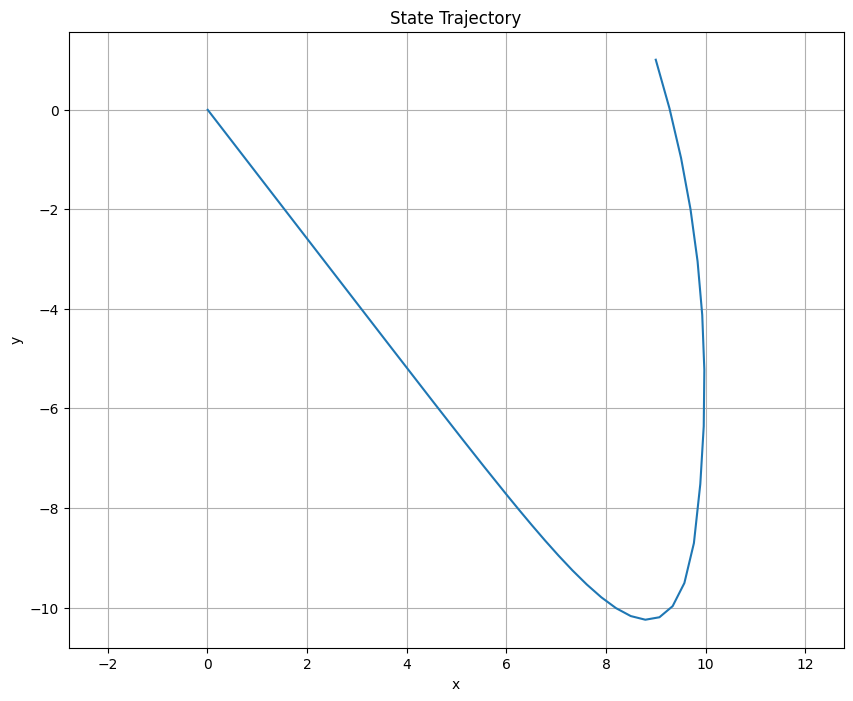

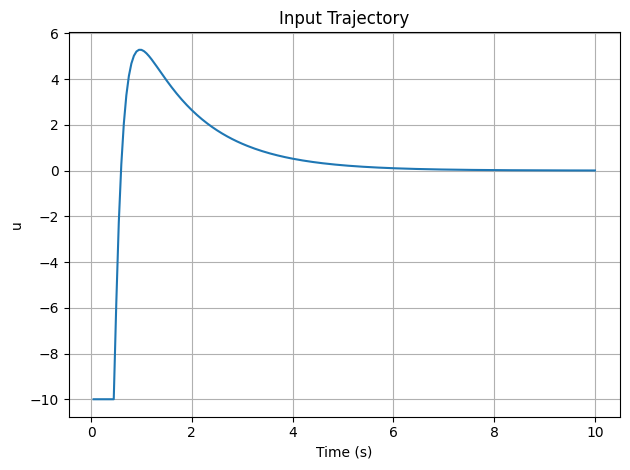

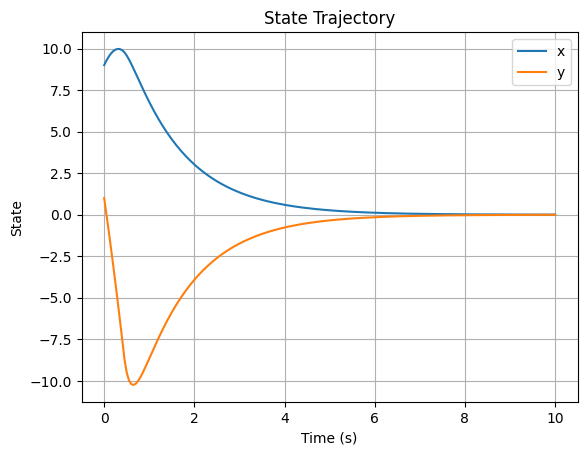

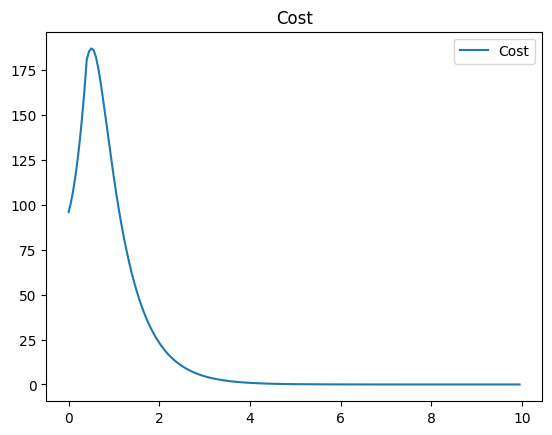

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))

plt.plot(x, y)
plt.title("State Trajectory")
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.axis('equal')  # Makes the axes equal (square aspect ratio)
plt.show()

plt.plot(t[1:], u)
plt.title("Input Trajectory")
plt.xlabel("Time (s)")
plt.ylabel("u")
plt.grid(True)

plt.tight_layout()  # Automatically adjusts spacing
plt.show()

plt.plot(t, x, label='x')
plt.plot(t, y, label='y')
plt.title("State Trajectory")
plt.xlabel("Time (s)")
plt.ylabel("State")
plt.grid(True)
plt.legend()
plt.show()


plt.plot(t[:-1], cost, label='Cost')
plt.title("Cost")
plt.legend()
plt.show()


Try pogo stick

In [37]:
# --- System parameters ---
m = 1.0  # Mass (kg)
k = 100.0  # Spring stiffness (N/m)
L0 = 1.0  # Spring rest length (m)
g = 9.81  # Acceleration due to gravity (m/s^2)
c = 1.5 # Damping coefficient (N·s/m)

def f(state, u):
    y = state[0]
    v = state[1]

    # Force calculation
    force_gravity = -m * g
    force_spring = ca.if_else(y <= L0, k * (L0 - y), 0.0)
    force_damping = ca.if_else(y <= L0, -c * v, 0.0)
    force_input = ca.if_else(y <= L0, u, 0.0)

    # Net force and acceleration
    net_force = force_gravity + force_spring + force_damping + force_input
    a = net_force / m

    return ca.vertcat(v, a)

def J(x, u):
    y_ref = 1.2
    
    # Use scalar operations instead of matrix operations
    reference_cost = (x[0] - y_ref)**2
    control_cost = 3.0 * u**2
    
    return  reference_cost + control_cost
# x_constraints = lambda x: ca.vertcat(x[0]-0.0, 10.0 - x[0], x[1]+10.0, 10.0 - x[1])
u_constraints = lambda u: ca.vertcat(u[0]-10.0, 10.0 - u[0])


In [38]:
x0 = np.array([L0, 0.0])
N = 50
mpc = MPC(
    N,
    f,
    J,
    n=2,
    m=1,
    dt = 0.01, 
    x_constraints=None,
    u_constraints=u_constraints
)
t, y, v, u, cost = simulate(x0, mpc, t_max=20.0)


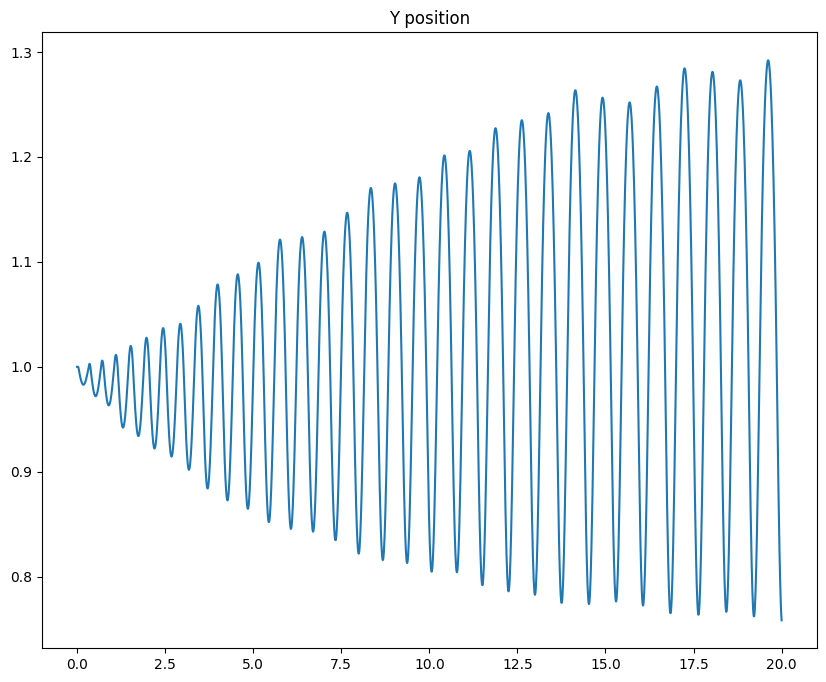

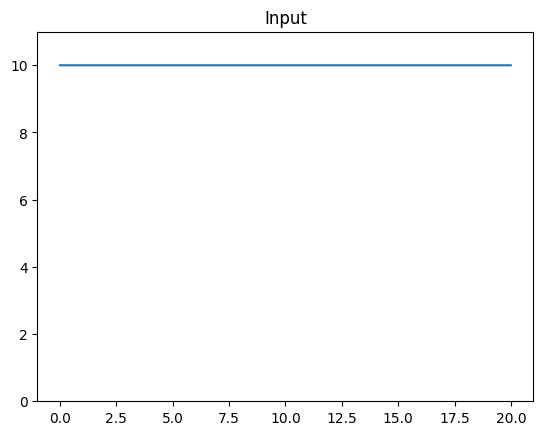

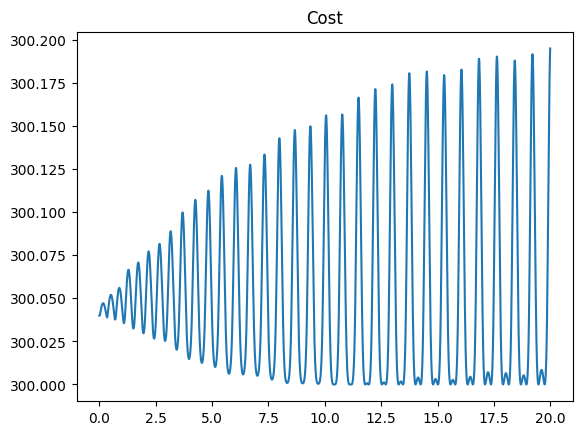

In [42]:
plt.figure(figsize=(10, 8))
plt.plot(t,y, label='y (position)')
plt.title('Y position')
plt.show()

plt.plot(t[:-1],u, label='u (input)')
plt.ylim([0,11])
plt.title('Input')
plt.show()

plt.plot(t[:-1], cost, label='cost')
plt.title('Cost')
plt.show()

Animate it!

In [40]:
import matplotlib.animation as animation
import os

def animate(x_hist, dt=0.05,
            save_path="animations/hopper_bounce.gif",
            fps=20, frame_skip=1):
    
    pos_hist = x_hist[0, :]

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_ylabel("Height (m)")
    ax.set_title('Vertical Spring-Mass Hopper Simulation')
    ax.axhline(y=0, color='r', label='Floor')
    # ax.axhline(y=L0, color='grey', linestyle='--', label='Spring Rest Length')
    ax.grid(True,zorder=0)
    ax.legend()
    ax.set_xticklabels([])
    ax.set_xlabel('')
    ax.set_xlim(-1,1)
    ax.set_ylim(0,max(pos_hist)+1)
    ax.set_aspect('equal')

    # Initialize the mass circle
    radius = 0.1
    mass_circle = plt.Circle((0, x_hist[0, 0]), radius, color='red')
    ax.add_patch(mass_circle)

    # Initialize the spring
    spring_line = plt.Line2D([0, 0], [0, x_hist[0, 0]], color='black', linewidth=4)
    ax.add_line(spring_line)

    # Add invisible elements for legend
    ax.plot([], [], 'ro', markersize=10, label='Mass')  # Invisible red circle for legend

    def animate_frame(frame):
        # Update mass position
        x_current = x_hist[:, frame]
        mass_circle.center = (0, x_current[0])

        # Update spring
        compression = L0 - x_current[0]
        if compression > 0:
            spring_line.set_data([0, 0], [0, (x_current[0]-(compression/2))])
        else:
            spring_line.set_data([0, 0], [x_current[0]-L0, x_current[0]-radius])
        return [mass_circle, spring_line]

    # Create animation frames
    frames = range(0, len(x_hist[0]), frame_skip)
    
    # Calculate correct interval:
    # Real time between frames = dt * frame_skip
    # Interval in milliseconds = (dt * frame_skip) * 1000
    interval_ms = dt * frame_skip * 1000

    anim = animation.FuncAnimation(
        fig, 
        animate_frame, 
        frames=frames,
        interval=interval_ms,  # Correct real-time interval
        blit=True,
        repeat=True
    )

    # Create animations directory if it doesn't exist
    animation_dir = "animations"
    os.makedirs(animation_dir, exist_ok=True)

    # Save GIF to the animations directory
    print(f"Saving animation to {save_path}...")
    anim.save(save_path, writer='pillow', fps=fps, dpi=100)
    print("Animation saved!")

    plt.show()


Saving animation to animations/hopper_bounce.gif...
Animation saved!


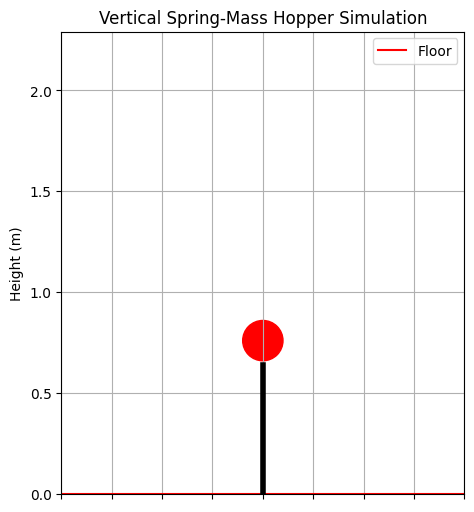

In [41]:
x_hist = np.array([y, v])
animate(x_hist, dt=mpc.dt, save_path="animations/hopper_bounce.gif", fps=20, frame_skip=5)
